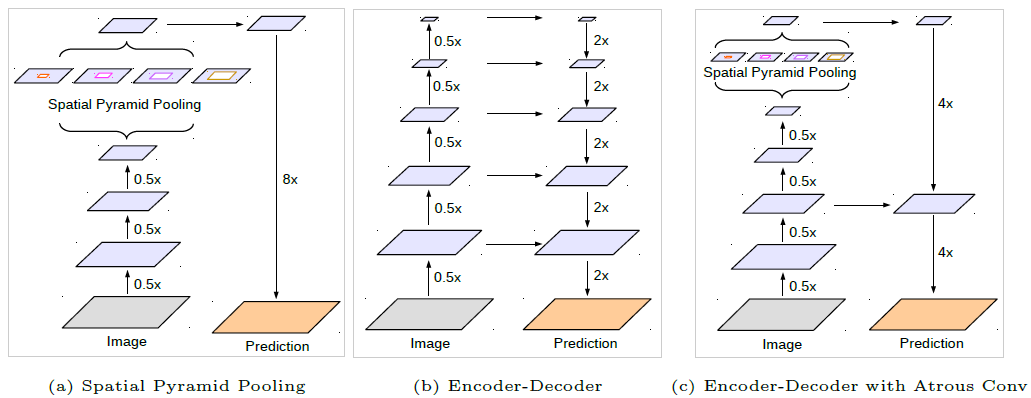

[Image reference](https://arxiv.org/pdf/1802.02611.pdf)

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Atrous Spatial Pyramid Convolution Module

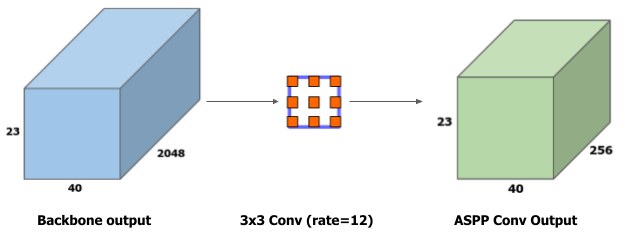

In [70]:
class aspp_conv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rate):
        super(aspp_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,
                      dilation=dilation_rate,
                      padding=dilation_rate,
                      bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

In [71]:
## Test with sample inputs
aspp_conv_test_input = torch.Tensor(2, 2048, 23, 40)
model = aspp_conv(in_channels=2048, out_channels=256, dilation_rate=6)
aspp_conv_test_output = model(aspp_conv_test_input)
print("aspp_conv_test_input.shape", aspp_conv_test_input.shape)
print("aspp_conv_test_output.shape", aspp_conv_test_output.shape)

aspp_conv_test_input.shape torch.Size([2, 2048, 23, 40])
aspp_conv_test_output.shape torch.Size([2, 256, 23, 40])


# ASPP Module (Atrous Spatial Pyramid Pooling)

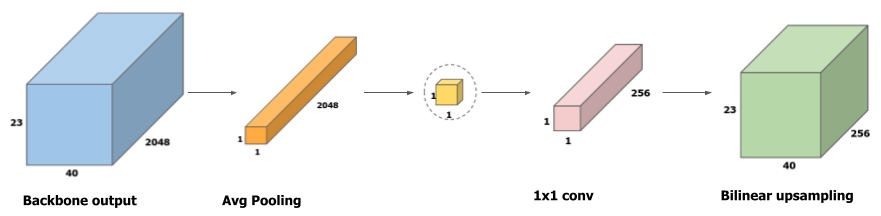

In [72]:
class aspp_pool(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(aspp_pool, self).__init__()
        self.pooling_module = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())

    def forward(self, x):
        input_size = x.shape[-2:]
        x = self.pooling_module(x)
        return F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)

In [73]:
## Test with sample inputs
aspp_pool_test_input = torch.Tensor(2, 2048, 23, 40)
model = aspp_conv(in_channels=2048, out_channels=256, dilation_rate=6)
aspp_pool_test_output = model(aspp_pool_test_input)
print("aspp_pool_test_input.shape", aspp_pool_test_input.shape)
print("aspp_pool_test_output.shape", aspp_pool_test_output.shape)

aspp_pool_test_input.shape torch.Size([2, 2048, 23, 40])
aspp_pool_test_output.shape torch.Size([2, 256, 23, 40])


## ASPP Module (Atrous Spatial Pyramid Pooling)

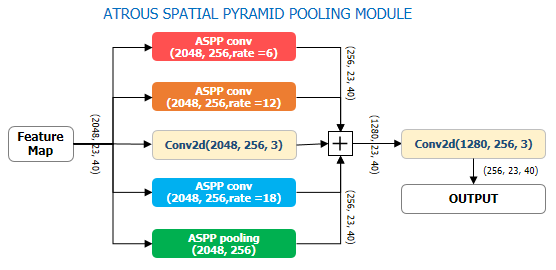

In [74]:
class atrous_spatial_pyramid_pooling(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rates):
        super(atrous_spatial_pyramid_pooling, self).__init__()

        layers = nn.ModuleList([])

        # skip connection, match the output channels
        # 1x1 conv
        layers.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1,
                      stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ))

        # Spatial pyramid pooling
        for rate in dilation_rates:
            layers.append(aspp_conv(in_channels, out_channels, rate))

        # pooling
        layers.append(aspp_pool(in_channels, out_channels))

        self.layers = nn.ModuleList(layers)

        # 1x1 convolution to project concatenated features to desired dimensionality
        self.project = nn.Sequential(
            nn.Conv2d(in_channels=len(layers) * out_channels,
                      out_channels=out_channels, kernel_size=1,
                      stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        conv_outputs = []
        for layer in self.layers:
            conv_outputs.append(layer(x))
        # Concatenate the outputs of each layer
        return self.project(torch.cat(conv_outputs, dim=1))

In [75]:
# test module with sample input
aspp_module_test_input = torch.Tensor(2, 2048, 23, 40)
aspp_module = atrous_spatial_pyramid_pooling(2048,
                       out_channels=256, dilation_rates=[6, 12, 18])
aspp_module_test_output = model(aspp_module_test_input)

# print result
print("aspp_module_test_input.shape", aspp_module_test_input.shape)
print("aspp_module_test_output.shape", aspp_module_test_output.shape)

aspp_module_test_input.shape torch.Size([2, 2048, 23, 40])
aspp_module_test_output.shape torch.Size([2, 256, 23, 40])


# DeepLabV3+ introduces a decoder module to refine the result.

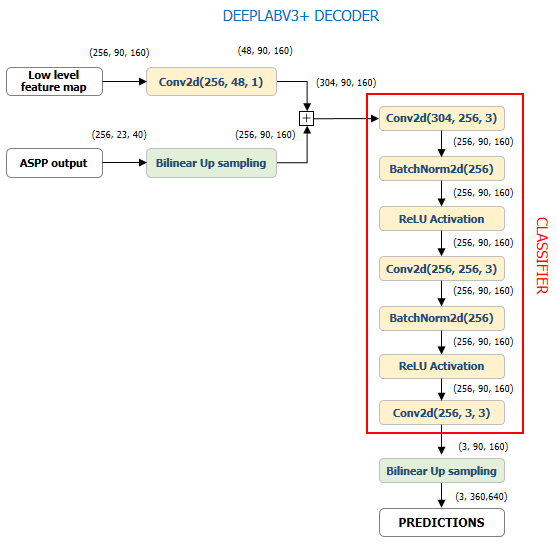

In [76]:
class deeplabv3_decoder(nn.Module):
    def __init__(self, num_classes):
        super(deeplabv3_decoder, self).__init__()
        self.num_classes = num_classes

        # resnet low level features contain 256 channels
        self.low_level_project = nn.Sequential(
            nn.Conv2d(256, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU())

        # classifier head
        self.cls = nn.Sequential(
            nn.Conv2d(304, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, self.num_classes, kernel_size=1))


    def forward(self, x, low_level_feat):
        # projected_low_level_feat = (48, h//4, w//4)
        low_level_feat = self.low_level_project(low_level_feat)

        # x = (256, h//4, w//4)
        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=False)

        # x = (256 + 48, h//4, w//4)
        x = torch.cat((x, low_level_feat), dim=1)

        # x = (num_classes, h//4, w//4)
        x = self.cls(x)
        return x

In [77]:
# test module with sample input
decoder_aspp_input = torch.Tensor(2, 256, 23, 40)
decoder_low_level_input = torch.Tensor(2, 256, 90, 360)

decoder_module = deeplabv3_decoder(num_classes=3)
decoder_test_output = decoder_module(decoder_aspp_input, decoder_low_level_input)

# print result
print("decoder_aspp_input.shape", decoder_aspp_input.shape)
print("decoder_low_level_input.shape", decoder_low_level_input.shape)
print("decoder_test_output.shape", decoder_test_output.shape)

decoder_aspp_input.shape torch.Size([2, 256, 23, 40])
decoder_low_level_input.shape torch.Size([2, 256, 90, 360])
decoder_test_output.shape torch.Size([2, 3, 90, 360])


In [78]:
import torchvision.models as models

class deeplabv3_plus(nn.Module):
    def __init__(self, in_channels, output_stride, num_classes):
        super(deeplabv3_plus, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.output_stride = output_stride

        if output_stride == 16:
            dilation_rates = [6, 12, 18]
            replace_stride_with_dilation = [False, False, True]

        elif output_stride == 8:
            dilation_rates = [12, 24, 36]
            replace_stride_with_dilation=[False, True, True]

        # backbone layers
        backbone = models.resnet152(weights=models.ResNet152_Weights.DEFAULT,replace_stride_with_dilation=replace_stride_with_dilation)

        self.initial = nn.Sequential(*list(backbone.children())[:4])
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4

        # ASPP modules
        aspp_out_channels = 256
        aspp_in_channels = int(backbone.fc.in_features)
        self.aspp_module = atrous_spatial_pyramid_pooling(aspp_in_channels,
                       out_channels=aspp_out_channels, dilation_rates=dilation_rates)

        # Decoder module
        self.decoder = deeplabv3_decoder(self.num_classes)

    def forward(self, x):
        input_size = x.shape[-2:]

        # Pass input through Backbone layers
        x = self.initial(x)
        low_level_feat = self.layer1(x)
        x = self.layer2(low_level_feat)
        x = self.layer3(x)
        x = self.layer4(x)

        # ASPP and classifier layers
        aspp_output = self.aspp_module(x)
        decoder_output = self.decoder(aspp_output, low_level_feat)
        return F.interpolate(decoder_output, size=input_size, mode='bilinear', align_corners=False)

In [79]:
import numpy as np

images = np.load("dataset/image_180_320.npy")
labels = np.load("dataset/label_180_320.npy")

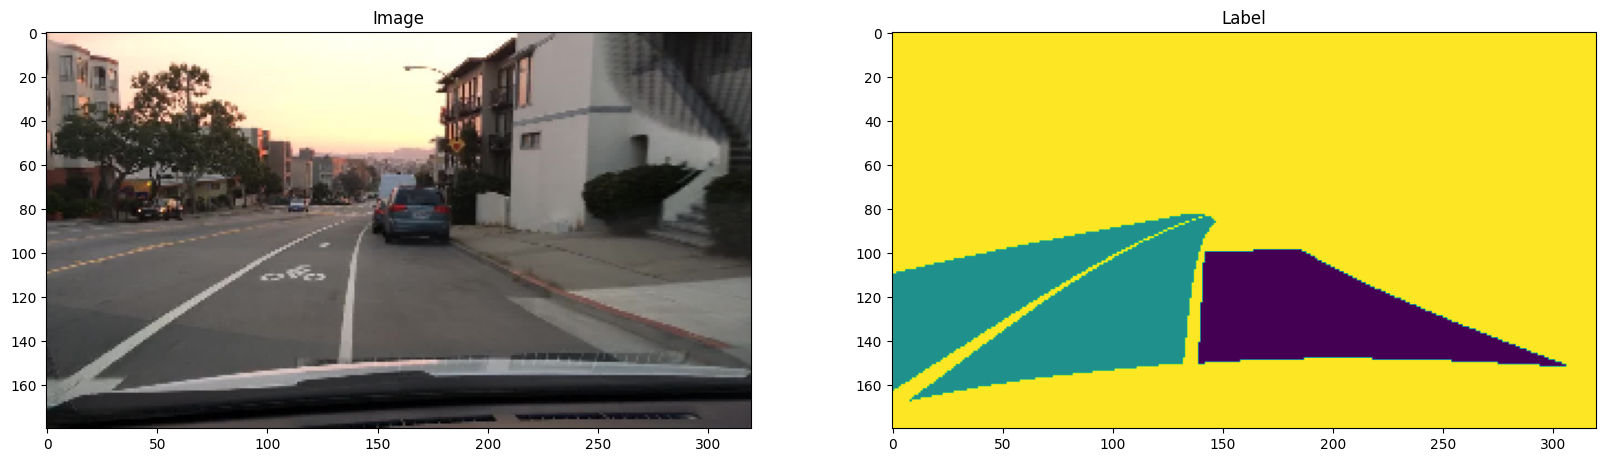

In [80]:
import matplotlib.pyplot as plt

_, (ax0, ax1) = plt.subplots(1,2, figsize=(20,40))
idx=255
ax0.imshow(images[idx])
ax0.set_title("Image")
ax1.imshow(labels[idx])
ax1.set_title("Label")
plt.show()

In [81]:
# utility functions to get BDD100k Pytorch dataset and dataloaders
from utils import get_datasets, get_dataloaders

train_set, val_set, test_set= get_datasets(images, labels)
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 180, 320]), output label shape = torch.Size([180, 320])


In [82]:
from collections import namedtuple

# Each label is a tuple with name, class id, and color
Label = namedtuple("Label", ["name", "id", "color"])
drivables = [
             Label("direct", 0, (171, 44, 236)),      # purple
             Label("alternative", 1, (86, 211, 19)),  # green
             Label("background", 2, (0, 0, 0)),       # black
            ]

train_id_to_color = [c.color for c in drivables if (c.id != -1 and c.id != 255)]
train_id_to_color = np.array(train_id_to_color)
print(f"train_id_to_color: {train_id_to_color}")

train_id_to_color: [[171  44 236]
 [ 86 211  19]
 [  0   0   0]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


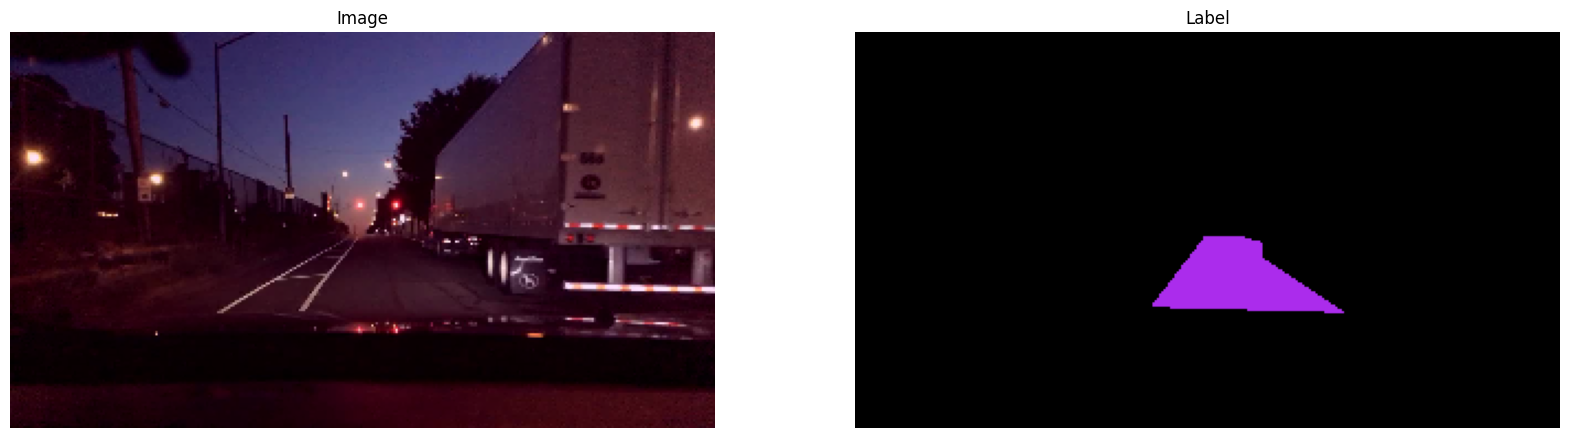

In [83]:
from utils import inverse_transform#, train_id_to_color

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
_, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image)
axes[0].set_title("Image")
axes[0].axis('off')
axes[1].imshow(train_id_to_color[label])
axes[1].set_title("Label")
axes[1].axis('off')
plt.show()

In [84]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function
from utils import pspnet_loss

Starting 1 epoch ...


100%|██████████| 138/138 [00:34<00:00,  3.99it/s]


Epoch: 1, trainLoss:0.77452, validationLoss:0.57012, meanIoU: 0.52
Starting 2 epoch ...


100%|██████████| 138/138 [00:49<00:00,  2.79it/s]


Epoch: 2, trainLoss:0.32449, validationLoss:0.40850, meanIoU: 0.66
Starting 3 epoch ...


100%|██████████| 138/138 [00:39<00:00,  3.45it/s]


Epoch: 3, trainLoss:0.16809, validationLoss:0.37207, meanIoU: 0.68
Starting 4 epoch ...


100%|██████████| 138/138 [00:35<00:00,  3.90it/s]


Epoch: 4, trainLoss:0.11131, validationLoss:0.33200, meanIoU: 0.69
Starting 5 epoch ...


100%|██████████| 138/138 [00:35<00:00,  3.90it/s]


Epoch: 5, trainLoss:0.09046, validationLoss:0.39457, meanIoU: 0.69
Starting 6 epoch ...


100%|██████████| 138/138 [00:42<00:00,  3.24it/s]


Epoch: 6, trainLoss:0.08151, validationLoss:0.31950, meanIoU: 0.71
Starting 7 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.80it/s]


Epoch: 7, trainLoss:0.10269, validationLoss:0.35082, meanIoU: 0.68
Starting 8 epoch ...


100%|██████████| 138/138 [00:35<00:00,  3.87it/s]


Epoch: 8, trainLoss:0.21301, validationLoss:0.37513, meanIoU: 0.70
Starting 9 epoch ...


100%|██████████| 138/138 [00:35<00:00,  3.86it/s]


Epoch: 9, trainLoss:0.14738, validationLoss:0.32730, meanIoU: 0.74
Starting 10 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.77it/s]


Epoch: 10, trainLoss:0.10202, validationLoss:0.42706, meanIoU: 0.72
Starting 11 epoch ...


100%|██████████| 138/138 [00:44<00:00,  3.13it/s]


Epoch: 11, trainLoss:0.18654, validationLoss:0.36852, meanIoU: 0.71
Starting 12 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.78it/s]


Epoch: 12, trainLoss:0.15014, validationLoss:0.46076, meanIoU: 0.71
Starting 13 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.74it/s]


Epoch: 13, trainLoss:0.19814, validationLoss:0.57056, meanIoU: 0.57
Starting 14 epoch ...


100%|██████████| 138/138 [00:37<00:00,  3.66it/s]


Epoch: 14, trainLoss:0.28770, validationLoss:0.39885, meanIoU: 0.67
Starting 15 epoch ...


100%|██████████| 138/138 [00:42<00:00,  3.22it/s]


Epoch: 15, trainLoss:0.17635, validationLoss:0.30489, meanIoU: 0.73
Starting 16 epoch ...


100%|██████████| 138/138 [00:39<00:00,  3.52it/s]


Epoch: 16, trainLoss:0.12558, validationLoss:0.53871, meanIoU: 0.70
Starting 17 epoch ...


100%|██████████| 138/138 [00:39<00:00,  3.51it/s]


Epoch: 17, trainLoss:0.10283, validationLoss:0.31968, meanIoU: 0.76
Starting 18 epoch ...


100%|██████████| 138/138 [00:37<00:00,  3.64it/s]


Epoch: 18, trainLoss:0.08203, validationLoss:0.34759, meanIoU: 0.75
Starting 19 epoch ...


100%|██████████| 138/138 [00:50<00:00,  2.71it/s]


Epoch: 19, trainLoss:0.07216, validationLoss:0.34377, meanIoU: 0.76
Starting 20 epoch ...


100%|██████████| 138/138 [00:50<00:00,  2.71it/s]


Epoch: 20, trainLoss:0.06884, validationLoss:0.35479, meanIoU: 0.76
Starting 21 epoch ...


100%|██████████| 138/138 [00:50<00:00,  2.71it/s]


Epoch: 21, trainLoss:0.06010, validationLoss:0.33656, meanIoU: 0.76
Starting 22 epoch ...


100%|██████████| 138/138 [00:51<00:00,  2.70it/s]


Epoch: 22, trainLoss:0.05199, validationLoss:0.33361, meanIoU: 0.77
Starting 23 epoch ...


100%|██████████| 138/138 [00:50<00:00,  2.72it/s]


Epoch: 23, trainLoss:0.04790, validationLoss:0.32709, meanIoU: 0.76
Starting 24 epoch ...


100%|██████████| 138/138 [00:50<00:00,  2.71it/s]


Epoch: 24, trainLoss:0.04417, validationLoss:0.28353, meanIoU: 0.77
Starting 25 epoch ...


100%|██████████| 138/138 [00:50<00:00,  2.73it/s]


Epoch: 25, trainLoss:0.04060, validationLoss:0.31955, meanIoU: 0.77
Starting 26 epoch ...


100%|██████████| 138/138 [00:51<00:00,  2.70it/s]


Epoch: 26, trainLoss:0.03710, validationLoss:0.30621, meanIoU: 0.77
Starting 27 epoch ...


100%|██████████| 138/138 [00:50<00:00,  2.72it/s]


Epoch: 27, trainLoss:0.03460, validationLoss:0.29826, meanIoU: 0.77
Starting 28 epoch ...


100%|██████████| 138/138 [00:50<00:00,  2.73it/s]


Epoch: 28, trainLoss:0.03275, validationLoss:0.28922, meanIoU: 0.77
Starting 29 epoch ...


100%|██████████| 138/138 [00:42<00:00,  3.24it/s]


Epoch: 29, trainLoss:0.03144, validationLoss:0.28964, meanIoU: 0.77
Starting 30 epoch ...


100%|██████████| 138/138 [00:35<00:00,  3.87it/s]


Epoch: 30, trainLoss:0.03056, validationLoss:0.27764, meanIoU: 0.77
Starting 31 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.79it/s]


Epoch: 31, trainLoss:0.02941, validationLoss:0.28911, meanIoU: 0.76
Starting 32 epoch ...


100%|██████████| 138/138 [00:35<00:00,  3.83it/s]


Epoch: 32, trainLoss:0.02887, validationLoss:0.27350, meanIoU: 0.77
Starting 33 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.75it/s]


Epoch: 33, trainLoss:0.02805, validationLoss:0.28963, meanIoU: 0.77
Starting 34 epoch ...


100%|██████████| 138/138 [00:39<00:00,  3.46it/s]


Epoch: 34, trainLoss:0.02658, validationLoss:0.30455, meanIoU: 0.76
Starting 35 epoch ...


100%|██████████| 138/138 [00:39<00:00,  3.50it/s]


Epoch: 35, trainLoss:0.02523, validationLoss:0.29550, meanIoU: 0.77
Starting 36 epoch ...


100%|██████████| 138/138 [00:38<00:00,  3.57it/s]


Epoch: 36, trainLoss:0.02409, validationLoss:0.28729, meanIoU: 0.77
Starting 37 epoch ...


100%|██████████| 138/138 [00:39<00:00,  3.53it/s]


Epoch: 37, trainLoss:0.02353, validationLoss:0.29054, meanIoU: 0.77
Starting 38 epoch ...


100%|██████████| 138/138 [00:57<00:00,  2.40it/s]


Epoch: 38, trainLoss:0.02302, validationLoss:0.29244, meanIoU: 0.77
Starting 39 epoch ...


100%|██████████| 138/138 [00:42<00:00,  3.24it/s]


Epoch: 39, trainLoss:0.02244, validationLoss:0.29814, meanIoU: 0.77
Starting 40 epoch ...


100%|██████████| 138/138 [00:42<00:00,  3.25it/s]


Epoch: 40, trainLoss:0.02132, validationLoss:0.29879, meanIoU: 0.77
Starting 41 epoch ...


100%|██████████| 138/138 [00:40<00:00,  3.42it/s]


Epoch: 41, trainLoss:0.02061, validationLoss:0.29396, meanIoU: 0.77
Starting 42 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.73it/s]


Epoch: 42, trainLoss:0.02004, validationLoss:0.29560, meanIoU: 0.77
Starting 43 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.80it/s]


Epoch: 43, trainLoss:0.01948, validationLoss:0.29416, meanIoU: 0.77
Starting 44 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.76it/s]


Epoch: 44, trainLoss:0.01908, validationLoss:0.29485, meanIoU: 0.77
Starting 45 epoch ...


100%|██████████| 138/138 [00:43<00:00,  3.16it/s]


Epoch: 45, trainLoss:0.01877, validationLoss:0.29413, meanIoU: 0.77
Starting 46 epoch ...


100%|██████████| 138/138 [00:39<00:00,  3.54it/s]


Epoch: 46, trainLoss:0.01854, validationLoss:0.29243, meanIoU: 0.77
Starting 47 epoch ...


100%|██████████| 138/138 [00:53<00:00,  2.57it/s]


Epoch: 47, trainLoss:0.01842, validationLoss:0.29223, meanIoU: 0.77
Starting 48 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.78it/s]


Epoch: 48, trainLoss:0.01833, validationLoss:0.29235, meanIoU: 0.77
Starting 49 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.77it/s]


Epoch: 49, trainLoss:0.01830, validationLoss:0.29280, meanIoU: 0.77
Starting 50 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.75it/s]


Epoch: 50, trainLoss:0.01826, validationLoss:0.29316, meanIoU: 0.77


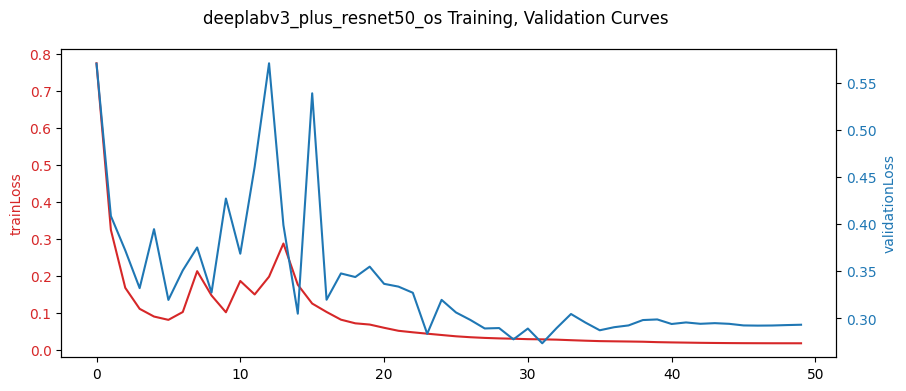

In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import segmentation_models_pytorch as smp

torch.cuda.empty_cache()

# MODEL HYPERPARAMETERS
N_EPOCHS = 50
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'deeplabv3_plus_resnet50_os'

output_path = 'dataset'

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
criterion = smp.losses.DiceLoss('multiclass', classes=[0,1,2], log_loss = True, smooth=1.0)

# create model, optimizer, lr_scheduler and pass to training function
model = deeplabv3_plus(in_channels=3, output_stride=8, num_classes=NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR, weight_decay=1e-4, betas=(0.9, 0.999), amsgrad=True)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader),
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer,
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

In [89]:
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} mean IoU in test set")


  0%|          | 0/69 [00:00<?, ?it/s]


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


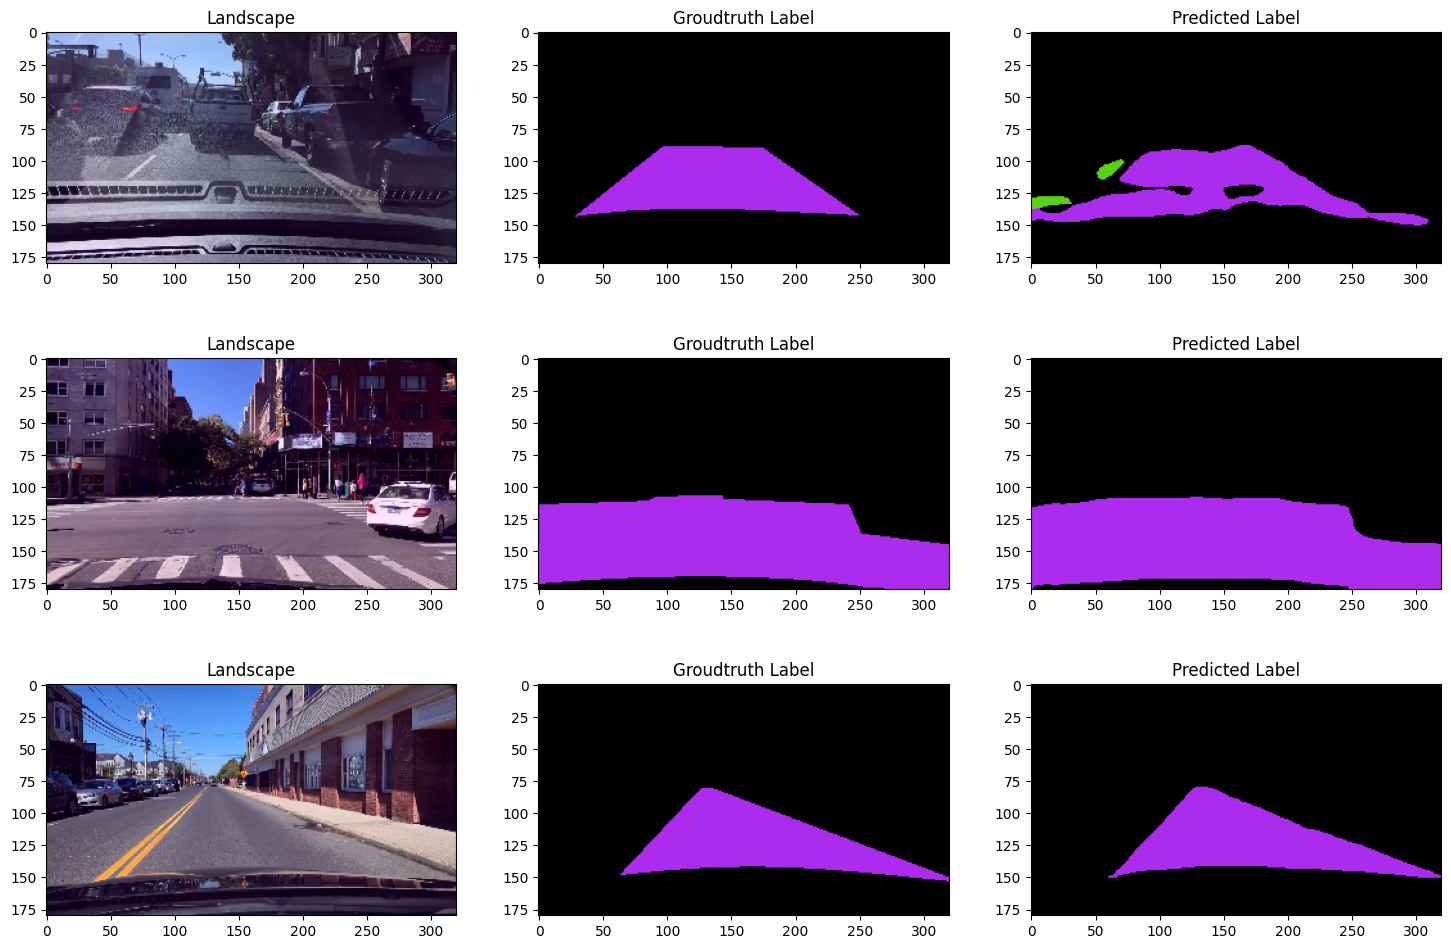

In [86]:
from utils import visualize_predictions

num_test_samples = 3
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_set, axes, device, numTestSamples=num_test_samples, id_to_color=train_id_to_color)

In [88]:
from utils import predict_video

model.cpu()

predict_video(model, "DeepLabV3+50epochs", "highway_1241_376.avi", "segmentation", 1241, 376, "cpu", train_id_to_color)

100%|██████████| 1170/1170 [1:43:07<00:00,  5.29s/it]
